In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from wpca import WPCA
from plotting import plot_dynamic_spectra, plot_lightcurve
import pandas as pd

In [19]:
def normalize(spectra):
    """
    Normalize a spectra to have values between 0 and 1.

    Parameters:
        spectra (numpy.ndarray): The input spectra.

    Returns:
        numpy.ndarray: The normalized spectra.
    """
    min_value = np.min(spectra)
    max_value = np.max(spectra)
    range_value = max_value - min_value


    normalized = (spectra - min_value) / range_value

    return normalized

In [20]:
# Define directories for the data
data_dir_scattered = "simulated_scattered_bursts"
data_dir_simple = "simulated_simple_bursts"

# Lists to store normalized lightcurves
normalized_lightcurves_scattered = []
normalized_lightcurves_simple = []
weights_scattered = []
weights_simple = []

# Loop through files in the scattered burst directory
for filename in os.listdir(data_dir_scattered):
    if filename.endswith(".npy"):
        # Load the dynamic spectra from the numpy array
        dynamic_spectra_w_pulse = np.load(os.path.join(data_dir_scattered, filename))

        # Calculate the lightcurve
        lightcurve = np.sum(dynamic_spectra_w_pulse, axis=1)

        # Normalize the lightcurve and append to the list
        normalized_lightcurve = normalize(lightcurve)
        normalized_lightcurves_scattered.append(normalized_lightcurve)

        weights_scattered.append(1/np.var(normalized_lightcurve[:200]))

# Loop through files in the simple burst directory
for filename in os.listdir(data_dir_simple):
    if filename.endswith(".npy"):
        # Load the dynamic spectra from the numpy array
        dynamic_spectra_w_pulse = np.load(os.path.join(data_dir_simple, filename))

        # Calculate the lightcurve
        lightcurve = np.sum(dynamic_spectra_w_pulse, axis=1)

        # Normalize the lightcurve and append to the list
        normalized_lightcurve = normalize(lightcurve)
        normalized_lightcurves_simple.append(normalized_lightcurve)

        weights_simple.append(1/np.var(normalized_lightcurve[:200]))

# Convert the lists to flat arrays
normalized_lightcurves_scattered = np.array(normalized_lightcurves_scattered)
normalized_lightcurves_simple = np.array(normalized_lightcurves_simple)

print(normalized_lightcurves_scattered.shape)
print(normalized_lightcurves_simple.shape)

# Combine the two datasets into one
combined_data = np.concatenate((normalized_lightcurves_scattered, normalized_lightcurves_simple), axis=0)
combined_weights = np.concatenate((weights_scattered, weights_simple), axis=0)

# Reshape the combined data for further analysis
combined_data_2d = combined_data.reshape(-1, 1024)

print(combined_data_2d.shape)
print(combined_weights.shape)


(1000, 1024)
(1000, 1024)
(2000, 1024)
(2000,)


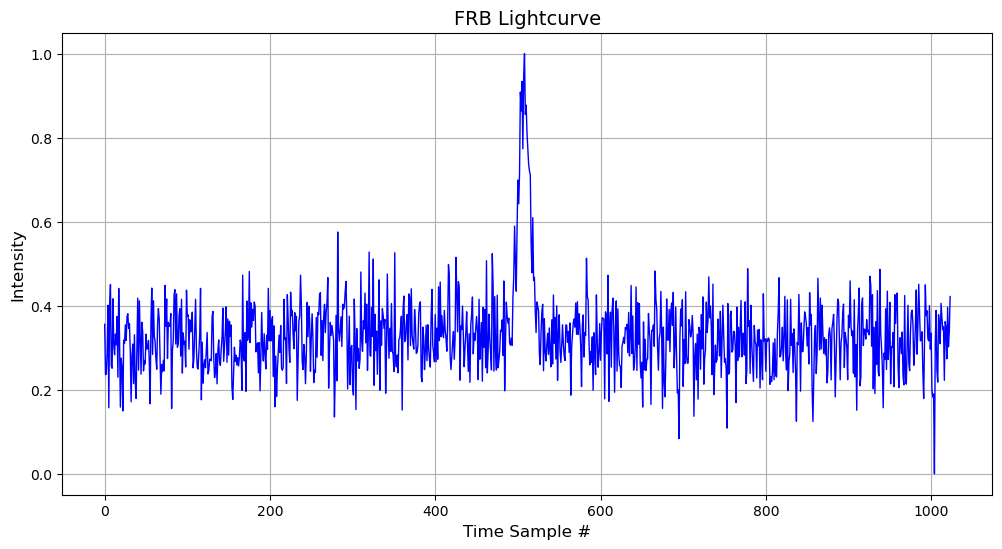

In [21]:
plot_lightcurve(np.arange(1024), normalized_lightcurves_scattered[0])

In [22]:
# Convert the weights list to a NumPy array and reshape it
weights = np.array(combined_weights).reshape(-1, 1)

# Expand the weights array to match the shape of combined_data_2d
weights = np.repeat(weights, 1024, axis=1)

print(weights.shape)

(2000, 1024)


In [25]:
# Create a WPCA instance and fit it to the data with weights
wpca = WPCA(n_components=2)  # Number of principal components to keep
wpca.fit(combined_data_2d, weights=weights)

WPCA(n_components=2)

In [28]:
transformed_fit = wpca.fit_transform(combined_data_2d)
wpca1 = wpca.transform(normalized_lightcurves_scattered)
wpca2 = wpca.transform(normalized_lightcurves_simple)

In [32]:
# Load the scattering times from the CSV files
data_info_simple = pd.read_csv("simulated_simple_bursts/simulated_simple_bursts.csv")
scattering_times_simple = data_info_simple['tau'].to_numpy()

data_info_scattered = pd.read_csv("simulated_scattered_bursts/simulated_scattered_bursts.csv")
scattering_times_scattered = data_info_scattered['tau'].to_numpy()

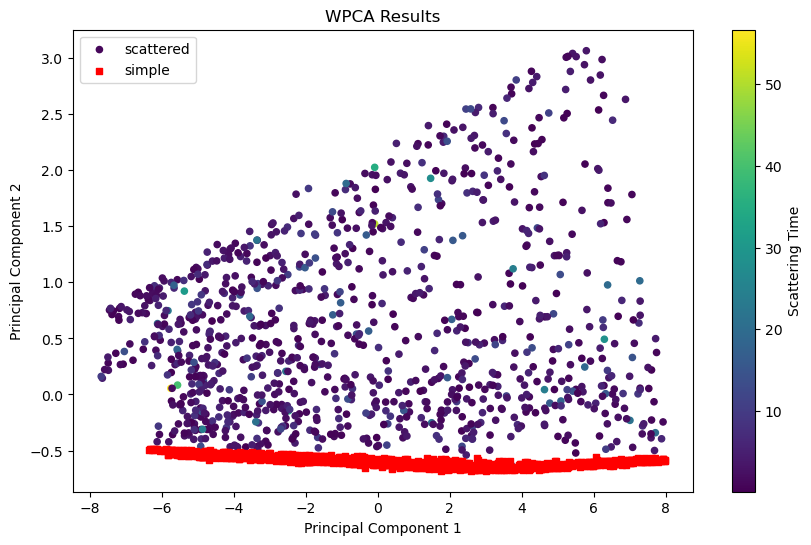

In [33]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot where points are colored by scattering times
scatter =plt.scatter(wpca1[:, 0], wpca1[:, 1], c=scattering_times_scattered, cmap='viridis', label='scattered', marker='o', s=20)
plt.scatter(wpca2[:, 0], wpca2[:, 1], c='r', label='simple', marker='s', s=20)

# Set axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set a title for the plot
plt.title('WPCA Results')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Scattering Time')

# Display a legend to differentiate the two datasets
plt.legend()

# Show the plot
plt.show()

